In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py, copy
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm, dates
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import pickle 
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *

from alvra_tools.utils import *
from alvra_tools.XAS_functions import *

import warnings
warnings.filterwarnings('ignore')

In [33]:
30 * 20 / 60

10.0

In [31]:
114 / (10000 / 250)

2.85

In [4]:
file = '/sf/alvra/data/p21739/raw/run0028-16M_check_reduction/data/acq0001.JF06T32V04.h5'
# with h5py.File(file, 'r') as f:
#     print("Keys: %s" % f.keys())
#     test = f['data']['JF06T32V04']['data'][0]
    
with ju.File(file) as juf:
    imgs = juf[0]
    
#imgs, pids = load_JF_static_batches(file, pgroup='p21739', nshots=10, batch_size = 10)

In [5]:
np.shape(imgs)

(4214, 4982)

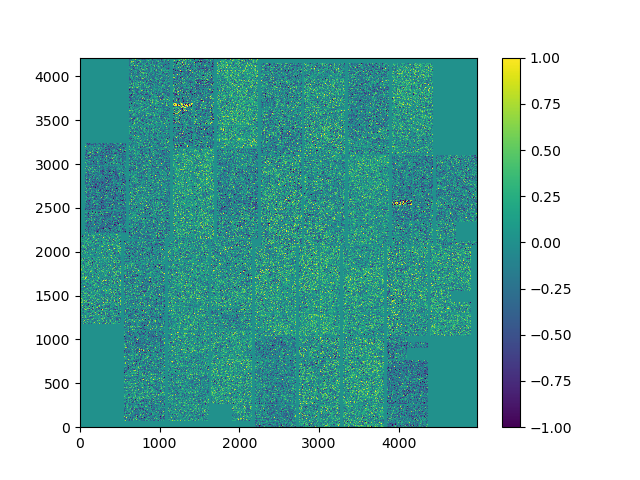

In [6]:
plt.figure()
plt.pcolormesh(imgs, vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [2]:
def creation_date(path_to_file):
    stat = os.stat(path_to_file)
    return stat.st_mtime



In [40]:
##### 16M test #####
detector = 'JF06T32V04'
run = 950
pgroup = 'p21010'

##### 4M  #####
# run = 106
# pgroup = 'p21600'

##### 16M calib #####
# run = 16
# pgroup = 'p21203'

##### 16M Tim #####
# run = 118
# pgroup = 'p21010'

#########################
savePNG = '/sf/alvra/data/{}/work/Claudio/PNG/'.format(pgroup)
nfiles = len(list(glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/acq*'.format(pgroup, run))))

print ('{} acquisitions found'.format(nfiles))

acqall = list(np.arange(1, nfiles, 1))
BSonly = []
JFonly = []
reqtime = []
jsononly = []
tdate = []
flag_noBS = False
for acq in acqall:
    ff = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/*{:04d}*json*'.format(pgroup, run, acq))[0]
    tdate.append(json.load(open(ff))['request_time'])
    t = time.mktime(time.strptime(json.load(open(ff))['request_time'],'%Y-%m-%d %H:%M:%S.%f'))
    reqtime.append(t)
    
    jsonf = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/*{:04d}*json*'.format(pgroup, run, acq))[0]
    try:
        JFf = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/data/*{:04d}*{}.h5*'.format(pgroup, run, acq, detector))[0]
        JFonly.append(creation_date(JFf))
    except:
        print("Acq {} not ready yet".format(acq))
        JFonly.append(np.nan)
    try:
        BSf = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/data/*{:04d}*BS*'.format(pgroup, run, acq))[0]
        BSonly.append(creation_date(BSf))
    except:
        flag_noBS=True
        BSonly.append(np.nan) #np.nan
    
    #JFonly.append(creation_date(JFf))
    jsononly.append(creation_date(jsonf))
if flag_noBS:
    print ('No BSDATA files found')

29 acquisitions found


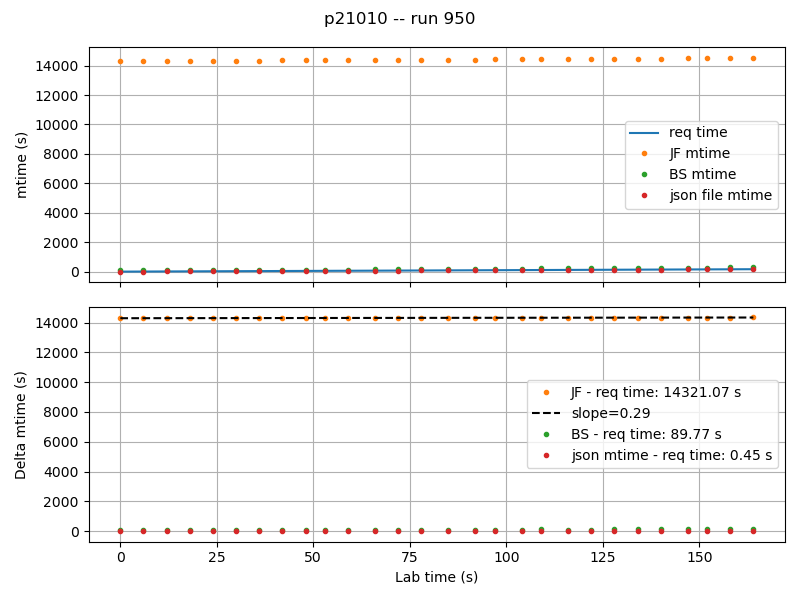

In [41]:
timeaxis = np.array(reqtime)-np.array(reqtime[0])

index = ~(np.isnan(timeaxis) | np.isnan(JFonly))
timeaxis = np.asarray(timeaxis)[index]
JFonly =  np.asarray(JFonly)[index]
BSonly = np.asarray(BSonly)[index]
reqtime = np.asarray(reqtime)[index]
jsononly = np.asarray(jsononly)[index]

m_JF,b_JF = np.polyfit(timeaxis, np.array(JFonly)- np.array(reqtime), 1)
#m_json, b_json = np.polyfit(timeaxis, jsononly, 1)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6), sharex=True)
plt.suptitle ('{} -- run {}'.format(pgroup, run))

offset = reqtime[0]

#ax1.plot(timeaxis, np.poly1d(np.polyfit(timeaxis, JFonly, 1))(timeaxis), color = 'black', linestyle = '--')
ax1.plot(timeaxis, reqtime - offset, label ='req time')
ax1.plot(timeaxis, JFonly - offset, '.', label ='JF mtime')
ax1.plot(timeaxis, BSonly - offset, '.', label ='BS mtime')
#ax1.plot(timeaxis, reqtime, label ='req time')
ax1.plot(timeaxis, jsononly - offset, '.', label ='json file mtime')

ax1.grid()
ax1.legend(loc='best')
ax1.set_ylabel('mtime (s)')

ax2.plot(timeaxis, np.array(JFonly)- np.array(reqtime), '.', label='JF - req time: {:.2f} s'.format(np.median(np.array(JFonly)[:38]- np.array(reqtime)[:38])), color = '#ff7f0e')
ax2.plot(timeaxis, np.poly1d(np.polyfit(timeaxis, np.array(JFonly)- np.array(reqtime), 1))(timeaxis), color = 'black', linestyle = '--', label='slope={:.2f}'.format(m_JF))
ax2.plot(timeaxis, np.array(BSonly)-np.array(reqtime), '.', label='BS - req time: {:.2f} s'.format(np.median(np.array(BSonly)- np.array(reqtime))), color = '#2ca02c')
ax2.plot(timeaxis, np.array(jsononly)- np.array(reqtime), '.', label='json mtime - req time: {:.2f} s'.format(np.mean(np.array(jsononly)- np.array(reqtime))), color='#d62728')
ax2.legend(loc='best')
ax2.grid()
ax2.set_ylabel('Delta mtime (s)')

# ax1.set_xlim(-100, 1900)
# ax1.set_ylim(-100, 4100)
# ax2.set_ylim(-100, 2100)

plt.xlabel('Lab time (s)')
plt.tight_layout()
plt.show()

os.makedirs(savePNG, exist_ok=True)
plt.savefig(savePNG + '/' + 'run{}.png'.format(run))


In [23]:
pgroup = 'p21010'
detector = 'JF06T32V04'
runlist = np.arange(900, 1000, 1)
#runlist = np.delete(runlist, np.where(runlist == 116))
#runlist = np.setdiff1d(runlist, [115, 116, 119, 122])
runlist

array([900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912,
       913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925,
       926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938,
       939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951,
       952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964,
       965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977,
       978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990,
       991, 992, 993, 994, 995, 996, 997, 998, 999])

In [32]:
BSonly = []
JFonly = []
reqtime = []
jsononly = []
trun = []
tdates = []

for run in runlist:
    nfiles = len(list(glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/acq*'.format(pgroup, run))))
    clear_output(wait=True)
    print ('Run: {}, {} acquisitions found'.format(run, nfiles))
    acqall = list(np.arange(1, nfiles, 1))
    flag_noBS = False
    for acq in acqall:
        #ff0 = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/acq0001.json'.format(pgroup, run))[0]
        ff  = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/*{:04d}*json*'.format(pgroup, run, acq))[0]
        tdate = json.load(open(ff))['request_time']
        tdates.append(tdate)
        t = time.mktime(time.strptime(tdate,'%Y-%m-%d %H:%M:%S.%f'))
        reqtime.append(t)
        if acq==1:
            trun.append(t)
        
        jsonf = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/*{:04d}*json*'.format(pgroup, run, acq))[0]
        JFf = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/data/*{:04d}*{}.h5*'.format(pgroup, run, acq, detector))[0]
        try:
            BSf = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/data/*{:04d}*BS*'.format(pgroup, run, acq))[0]
            BSonly.append(creation_date(BSf))
        except:
            flag_noBS=True
            BSonly.append(np.nan) #np.nan

        JFonly.append(creation_date(JFf))
        jsononly.append(creation_date(jsonf))
    if flag_noBS:
        print ('No BSDATA files found')

Run: 999, 29 acquisitions found


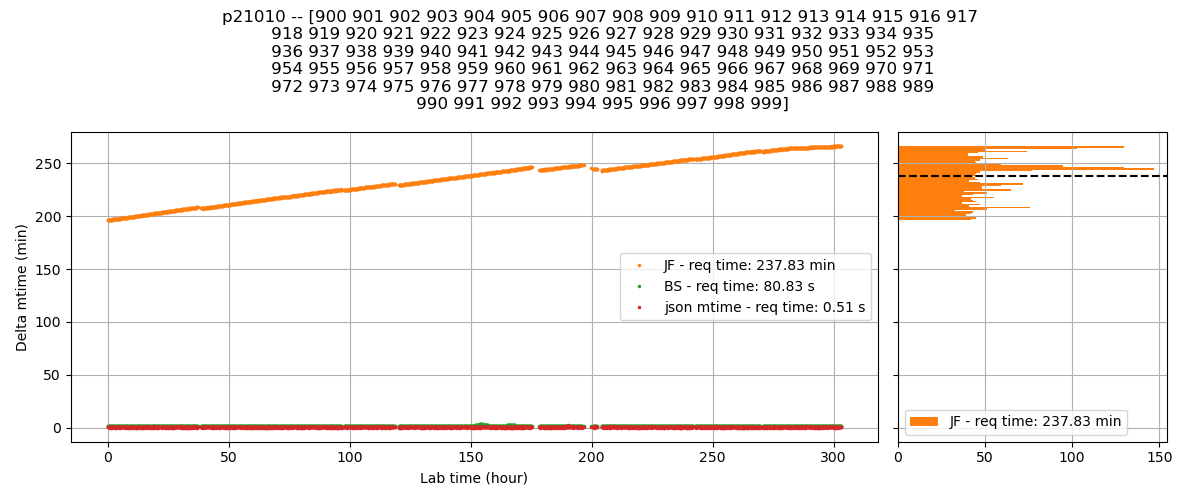

In [33]:
#timeaxis = (np.array(reqtime)-np.array(reqtime[0]))/3600
timeaxis = (np.array(reqtime)-np.array(reqtime[0]))/60
trunaxis = (np.array(trun)-np.array(trun[0]))/3600

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True, gridspec_kw={'width_ratios': [3, 1]})
plt.suptitle ('{} -- {}'.format(pgroup, runlist))

JFtimes = (np.array(JFonly)- np.array(reqtime))/60
BStimes = (np.array(BSonly)-np.array(reqtime))/60
jsontimes = (np.array(jsononly)- np.array(reqtime))

ax2.hist(JFtimes, bins = 50, orientation=u'horizontal', label='JF - req time: {:.2f} min'.format(np.median(JFtimes)), color='#ff7f0e')
ax2.axhline(y= np.median(JFtimes), color='black', linestyle='--')
ax2.legend(loc='best')
ax2.grid()

ax1.plot(timeaxis, JFtimes, '.',  ms=3, label='JF - req time: {:.2f} min'.format(np.median(JFtimes)), color = '#ff7f0e')
ax1.plot(timeaxis, BStimes, '.', ms=3, label='BS - req time: {:.2f} s'.format(np.median(BStimes)*60), color = '#2ca02c')
ax1.plot(timeaxis, jsontimes, '.',  ms=3, label='json mtime - req time: {:.2f} s'.format(np.median(jsontimes)), color='#d62728')
#ax1.vlines(x= trunaxis, color='black', linestyle='--', ymin=0, ymax=max(JFtimes))
ax1.legend(loc='best')
ax1.grid()
ax1.set_ylabel('Delta mtime (min)')

ax1.set_xlabel('Lab time (hour)')

#ax1.set_ylim(-10, 400)

plt.tight_layout()
plt.show()


In [174]:
3.2*60*60*24/1000

276.48

In [175]:
120/24

5.0

In [95]:
def creation_date(path_to_file):
    stat = os.stat(path_to_file)
    return stat.st_mtime
    #return time.strftime('%H:%M:%S', time.localtime(stat.st_mtime) )
    # try:
    #     print('birthtime')
    #     return stat.st_birthtime
    # except AttributeError:
    #     return stat.st_mtime


In [123]:
reqtime =json.load(open(glob.glob('/sf/alvra/data/p21597/raw/*{:04d}*/meta/*{:04d}*json*'.format(run, acq))[0]))['request_time']
data['request_time']

'2024-03-05 15:45:44.018084'

In [25]:
file = '/sf/alvra/data/p21600/raw/run0015-x63_50mJ_1ms/data/acq0001.JF06T08V04.h5'
with h5py.File(file, 'r') as f:
    print("Keys: %s" % f.keys())
    test = f['data']['JF06T08V04']['data'][0]
    
with ju.File(file) as juf:
    test2 = juf[0]

Keys: <KeysViewHDF5 ['data', 'general']>


In [26]:
print (test.ravel()[0:10])
print (test2.ravel()[0:10])

[401 274 210 145 152 121 111  59 118 293]
[100.25  68.5   52.5   36.25  38.    30.25  27.75  14.75  29.5   73.25]


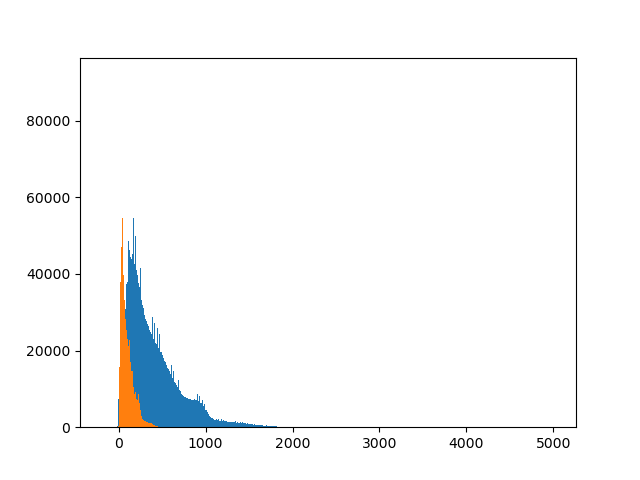

In [27]:
plt.figure()
plt.hist(test.ravel(), bins =1000)
plt.hist(test2.ravel(), bins =1000)

plt.show()

In [5]:
pgroup='p21010'
runnumber = 50
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0050


'/sf/alvra/data/p21010/raw/run0050-Laser_rot/meta/scan.json'

In [6]:
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan

SFScanInfo("/sf/alvra/data/p21010/raw/run0050-Laser_rot/meta/scan.json"): 21 steps

In [7]:
channel_list = ["SLAAR11-CPCW-SPEC01:SPECTRUM"]

single_acq = 10

#################################################

all_results = []
step = scan[single_acq]

check_files_and_data(step)
check = get_filesize_diff(step) 
if check:
    clear_output(wait=True)
    filename = scan.files[single_acq-1][0].split('/')[-1].split('.')[0]  
    print ('Processing {}'.format(filename))

    results,pids = load_data_compact(channel_list, step)

    all_results.append(results)

Processing acq0010

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet      501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-CPCW-SPEC01:SPECTRUM 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 501 / 501 -> 0% loss
complete channels: 2 / 2 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz


In [8]:
spec = results["SLAAR11-CPCW-SPEC01:SPECTRUM"]
np.shape(spec)

(501, 2068)

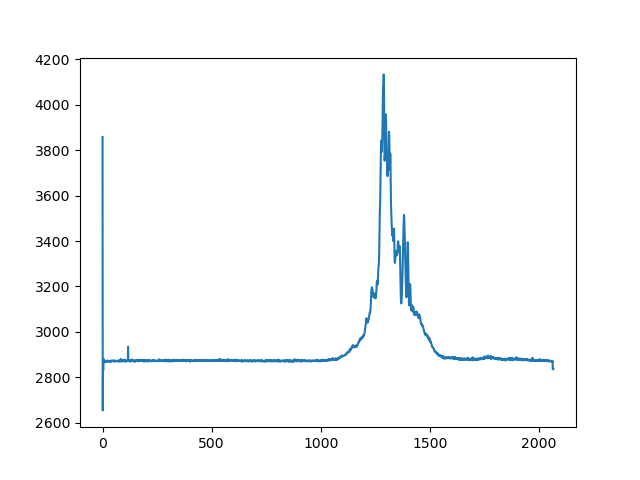

In [10]:
plt.figure()
plt.plot(spec.mean(axis=0))
plt.show()

In [14]:
np.savetxt('/sf/alvra/data/p21010/work/Claudio/spec.txt', spec.mean(axis=0))
np.save('/sf/alvra/data/p21010/work/Claudio/spec', spec.mean(axis=0))

# Table of Contents:
* [Check position jetter](#pbps_noise)
* [Load PSSS vs time](#psss_com)


In [2]:
pgroup='p21010'
runnumber = 50
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0050


'/sf/alvra/data/p21010/raw/run0050-Laser_rot/meta/scan.json'

In [3]:
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan

SFScanInfo("/sf/alvra/data/p21010/raw/run0050-Laser_rot/meta/scan.json"): 21 steps

In [4]:
channel_list = [channel_PSSS_y, channel_PSSS_x]

single_acq = 10

#################################################

all_results = []
step = scan[single_acq]

check_files_and_data(step)
check = get_filesize_diff(step) 
if check:
    clear_output(wait=True)
    filename = scan.files[single_acq-1][0].split('/')[-1].split('.')[0]  
    print ('Processing {}'.format(filename))

    results,pids = load_data_compact(channel_list, step)

    all_results.append(results)

Processing acq0010

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet      501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-CPCW-SPEC01:SPECTRUM 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 501 / 501 -> 0% loss
complete channels: 2 / 2 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz


In [19]:
PSSSy = results[channel_PSSS_y]
PSSSx  = results[channel_PSSS_x]
np.shape(PSSSx)

(1001, 2560)

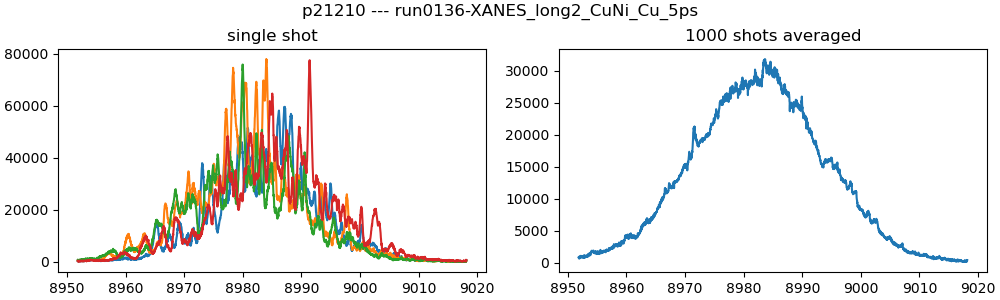

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
plt.suptitle(titlestring)
for index in range(4):
    ax1.plot(PSSSx[0], PSSSy[index])
ax1.set_title("single shot")
ax2.plot(PSSSx[0], np.average(PSSSy, axis=0))
ax2.set_title("1000 shots averaged")
plt.show()

<a id='pbps_noise'></a>
## Position jitter

In [179]:
pgroup='p21621'
runnumber = 96
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0096


'/sf/alvra/data/p21621/raw/run0096-diazocine_c6_10_2_a_15ps_Xray5p_5uJ/meta/scan.json'

In [180]:
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan

SFScanInfo("/sf/alvra/data/p21621/raw/run0096-diazocine_c6_10_2_a_15ps_Xray5p_5uJ/meta/scan.json"): 69 steps

## Single acquisition

In [181]:
channel_list = [channel_posX_122, channel_posY_122]

single_acq = 25

#################################################

all_results = []
step = scan[single_acq]

check_files_and_data(step)
check = get_filesize_diff(step) 
if check:
    clear_output(wait=True)
    filename = scan.files[single_acq-1][0].split('/')[-1].split('.')[0]  
    print ('Processing {}'.format(filename))

    results,pids = load_data_compact(channel_list, step)

    all_results.append(results)

Processing acq0025

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet 5001 / 5001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:XPOS    5001 / 5001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:YPOS    5001 / 5001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 5001 / 5001 -> 0% loss
complete channels: 3 / 3 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz


## Take all the acquisitions of the run

In [39]:
channel_list = [channel_posX_122, channel_posY_122]

#################################################

all_results = []
for i, step in enumerate(scan[:-1]):
    check_files_and_data(step)
    check = get_filesize_diff(step) 
    if check:
        clear_output(wait=True)
        filename = scan.files[i][0].split('/')[-1].split('.')[0] 
        print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
        
        results,pids = load_data_compact(channel_list, step)

        all_results.append(results)

Step 99 of 100: Processing acq0099

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:XPOS    1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:YPOS    1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1001 / 1001 -> 0% loss
complete channels: 3 / 3 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz


In [182]:
xpos = []
ypos = []
for index in range(len(all_results)):
    xpos.extend(all_results[index][channel_posX_122])
    ypos.extend(all_results[index][channel_posY_122])
xpos = np.asarray(xpos)
ypos = np.asarray(ypos)
np.shape(xpos)

(5001,)

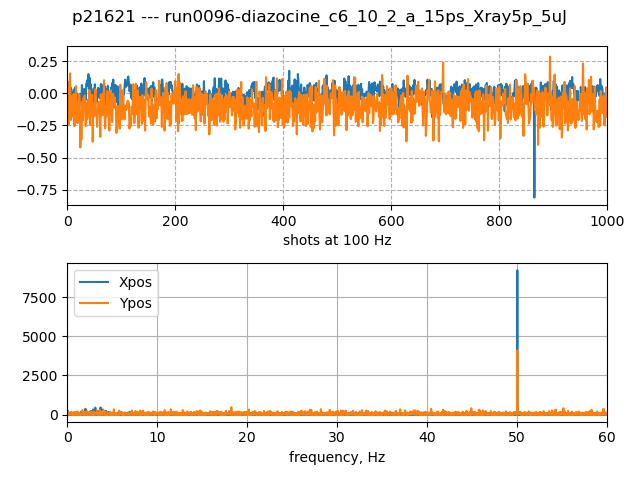

In [183]:
#x=np.arange(0,100,0.05)
x = np.linspace(0,100,len(xpos)*2)
valsdiode = np.hstack((xpos-np.mean(xpos), np.zeros_like(xpos)))
vals2diode = np.hstack((ypos - np.mean(ypos), np.zeros_like(ypos)))
powerx = np.abs(np.fft.fft(valsdiode))**2
powery = np.abs(np.fft.fft(vals2diode))**2

fig, axs = plt.subplots(2, 1)
plt.suptitle(titlestring)
axs[0].plot(valsdiode)
axs[0].plot(vals2diode-0.1)
#axs[0].set_xlim(0,len(xpos))
axs[0].set_xlim(0,min(len(xpos), 1000))
axs[0].set_xlabel('shots at 100 Hz')
axs[0].grid(True, linestyle='--')

axs[1].plot(x, powerx, label ="Xpos")
axs[1].plot(x, powery, label ="Ypos")
axs[1].set_xlabel('frequency, Hz')
axs[1].set_xlim(0,60)
plt.legend(loc='best')
#axs[1].set_ylim(0,100)
axs[1].grid(True)
fig.tight_layout()
plt.show()

In [42]:
pgroup = 'p21210'
reducedir='/das/work/p21/p21533/Claudio/Reduced_data_pos/'

runlist = np.arange(0, 50, 1)

datafiles = []
print (runlist)
for run in runlist:
    file = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, run))
    datafiles.extend(file)
#datafiles    


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


In [43]:
channel_list = [channel_posX_122, channel_posY_122, channel_posX_110, channel_posY_110]

#################################################
from sfdata import SFScanInfo

#all_results = []

for j,json_file in enumerate(datafiles):
    scan = SFScanInfo(json_file)
    all_results = []
    all_pids = []
    for i, step in enumerate(scan):
        if (len(step.all_pids)) > 250:
            check_files_and_data(step)
            check = get_filesize_diff(step) 
            if check:
                clear_output(wait=True)
                print ('{}/{}: {}'.format(j+1, len(datafiles), json_file))
                filename = scan.files[i][0].split('/')[-1].split('.')[0] 
                print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))

                results,pids = load_data_compact(channel_list, step)

                all_results.append(results)
                all_pids.append(pids)
            run_name = json_file.split('/')[-3]
            loaddata = reducedir+run_name
            os.makedirs(reducedir, exist_ok=True)
            data = {}
            data ={"all_results": all_results, "pids": all_pids}
            with open(loaddata+'_data.pkl', 'wb') as f:
                pickle.dump(data, f)


49/49: /sf/alvra/data/p21210/raw/run0049-Timescan_long2_CuNi_Ni_8334_001/meta/scan.json
Step 56 of 56: Processing acq0056

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:XPOS     982 / 1001 -> 2% loss ▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:YPOS     982 / 1001 -> 2% loss ▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:XPOS     974 / 1001 -> 3% loss ▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:YPOS     974 / 1001 -> 3% loss ▇▇▇▇▇▇▇▇▇

over the whole data set: 955 / 1001 -> 5% loss
complete channels: 1 / 5 -> 80% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz


In [44]:
file = glob.glob('/sf/alvra/data/{}/work/Claudio/Reduced_data_pos/*data*.pkl'.format(pgroup))
file = np.sort(file)
nshots = []
all_results = []
for f in file:
    with open(f, 'rb') as ff:
        temp_dict = pickle.load(ff)
        #all_results.extend(temp_dict["all_results"])
        for index in range(len(temp_dict["all_results"])):
            if len(temp_dict["all_results"][index]['SAROP11-PBPS110:XPOS']) < 240:
                print (ff)
        all_results.extend(temp_dict["all_results"])
        #    nshots.append(len(temp_dict["all_results"][index]['SAROP11-PBPS110:XPOS']))
print (np.shape(all_results))

(0,)


In [10]:
powerx = []
ypos = []
for index in range(len(all_results)):
    xpos = all_results[index][channel_posX_110][:240]
    x = np.linspace(0,100,len(xpos)*2)
    valsdiode = np.hstack((xpos-np.mean(xpos), np.zeros_like(xpos)))
    powerx.append(np.abs(np.fft.fft(valsdiode))**2)
    
    # xpos.append(all_results[index][channel_posX_110][:4000])
    # ypos.append(all_results[index][channel_posY_110][:4000])
    
powerx = np.asarray(powerx)
# ypos = np.asarray(ypos)
print (np.shape(powerx), np.shape(x))

(6638, 480) (480,)


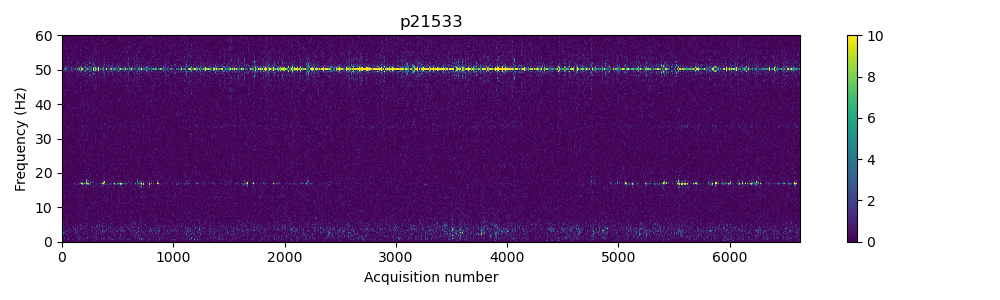

In [14]:
y = np.arange(len(powerx))
plt.figure(figsize=(10,3))
plt.title(pgroup)
plt.pcolormesh(y, x, powerx.T, vmin = 0, vmax = 10)
#plt.pcolormesh(all_Delay_fs_TT_noNans, y_axis_rebin, on_2D, vmin = vmin, vmax = vmax)
plt.ylim(0,60)
plt.xlabel('Acquisition number')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.tight_layout()
plt.show()

<a id='psss_com'></a>
## check PSSS com vs time

In [15]:
def timestamp(json_file):
    file_split = json_file.split('/')[:-1]
    path_to_bsdata = '/'.join([*file_split[:-1], 'data', '*BSDATA.h5'])
    
    timestamp_s = []
    
    for file in glob.glob(path_to_bsdata):
        with h5py.File(file) as f:
            timestamp_ns = f[channel_Events]['timestamp'][:]
            timestamp_s.append(np.mean(timestamp_ns) * 1e-9)
    timestamp_s = np.mean(timestamp_s)
    timestamp_datetime = datetime.fromtimestamp(timestamp_s)
    return np.datetime64(timestamp_datetime)

def timestamp_step(step):
    bsdata = step.fnames[0]
    timestamp_s = []
    with h5py.File(bsdata) as f:
        timestamp_ns = f[channel_Events]['timestamp'][:]
        timestamp_s.append(np.mean(timestamp_ns) * 1e-9)
    timestamp_s = np.mean(timestamp_s)
    timestamp_datetime = datetime.fromtimestamp(timestamp_s)
    return np.datetime64(timestamp_datetime)

In [17]:
pgroup = 'p21209'
reducedir='../Claudio/Reduced_data/'

runlist = np.arange(618, 808, 1)

datafiles = []
print (runlist)
for run in runlist:
    file = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, run))
    datafiles.extend(file)
#datafiles    


[618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635
 636 637 638 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653
 654 655 656 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671
 672 673 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689
 690 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707
 708 709 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725
 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743
 744 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761
 762 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779
 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797
 798 799 800 801 802 803 804 805 806 807]


In [18]:
channel_list = ['SARFE10-PSSS059:FIT-COM', "SARFE10-PBPG050:HAMP-INTENSITY-CAL"]

#################################################
from sfdata import SFScanInfo

all_results = []
psss_com = []
timestamps_npy = []
pulseEnergy = []
timestamps = []

for j,json_file in enumerate(datafiles):
    scan = SFScanInfo(json_file)
    psss_com_run=[]
    pulseEnergy_run = []
    timestamps_run = []
    for i, step in enumerate(scan):
        check_files_and_data(step)
        check = get_filesize_diff(step) 
        if check:
            clear_output(wait=True)
            print ('{}/{}: {}'.format(j+1, len(datafiles), json_file))
            timestamps_run.append( timestamp_step(step) )
            filename = scan.files[i][0].split('/')[-1].split('.')[0]
            print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))

            results,pids = load_data_compact(channel_list, step)
            temp = results['SARFE10-PSSS059:FIT-COM']
            psss_com_run.append(np.average(results['SARFE10-PSSS059:FIT-COM']))
            psss_com.append(np.average(results['SARFE10-PSSS059:FIT-COM']))
            
            pulseEnergy.append(np.average(results["SARFE10-PBPG050:HAMP-INTENSITY-CAL"]))
            pulseEnergy_run.append(np.average(results["SARFE10-PBPG050:HAMP-INTENSITY-CAL"]))
            timestamps.append(timestamp_step(step))
            
            all_results.append(results)
            
        run_name = json_file.split('/')[-3]
        loaddata = reducedir+run_name
        os.makedirs(reducedir, exist_ok=True)
        data = {}
        data ={"psss": psss_com_run, "pulseEnergy": pulseEnergy_run, "timestamp": timestamps_run}
        with open(loaddata+'_data.pkl', 'wb') as f:
            pickle.dump(data, f)
#        np.save(loaddata+'_data', data)
 #       np.save(loaddata+'_pulseEnergy_data.npy', pulseEnergy_run)
 #       np.save(loaddata+'_timestamps.npy',timestamps_npy)

190/190: /sf/alvra/data/p21209/raw/run0807-CcO_LowpH_DTBA_4OMe_5ms/meta/scan.json
Step 29 of 29: Processing acq0029

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet            201 / 201 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARFE10-PBPG050:HAMP-INTENSITY-CAL 201 / 201 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARFE10-PSSS059:FIT-COM            201 / 201 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 201 / 201 -> 0% loss
complete channels: 3 / 3 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz


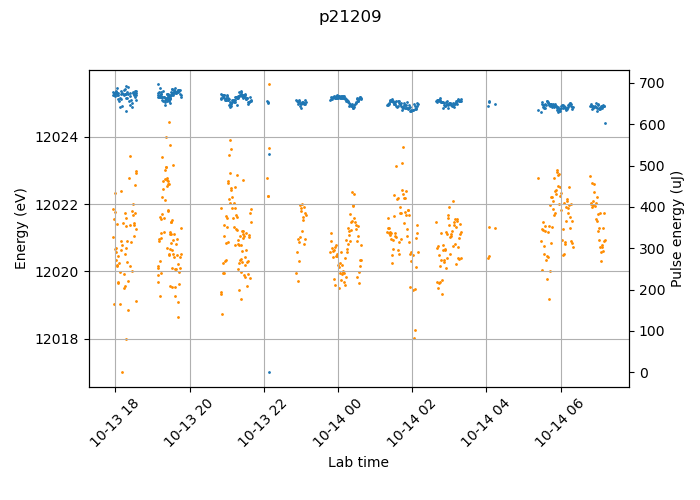

In [19]:
fig = plt.figure(figsize = (7,5))
plt.suptitle(pgroup)

ax1 = fig.add_subplot(111)
ax2 = plt.twinx(ax1)

ax1.scatter(timestamps, psss_com, color = 'darkorange', s=1)
ax2.scatter(timestamps, pulseEnergy, s=1)

ax1.tick_params('x', labelrotation=45)
ax1.set_ylabel('Energy (eV)')
ax2.set_ylabel('Pulse energy (uJ)')
ax1.set_xlabel('Lab time')
#ax1.set_ylim(12020, 12060)

ax1.grid()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [20]:
file = glob.glob('/sf/alvra/data/{}/work/Claudio/Reduced_data/*data*.pkl'.format(pgroup))
file = np.sort(file)

psss_com = []
pulseEnergy = []
timestamps = []
for f in file:
    with open(f, 'rb') as ff:
        temp_dict = pickle.load(ff)
        psss_com.extend(temp_dict["psss"])
        pulseEnergy.extend(temp_dict["pulseEnergy"])
        timestamps.extend(temp_dict["timestamp"])
print (len(psss_com), len(pulseEnergy), len(timestamps))

2911 2911 2911


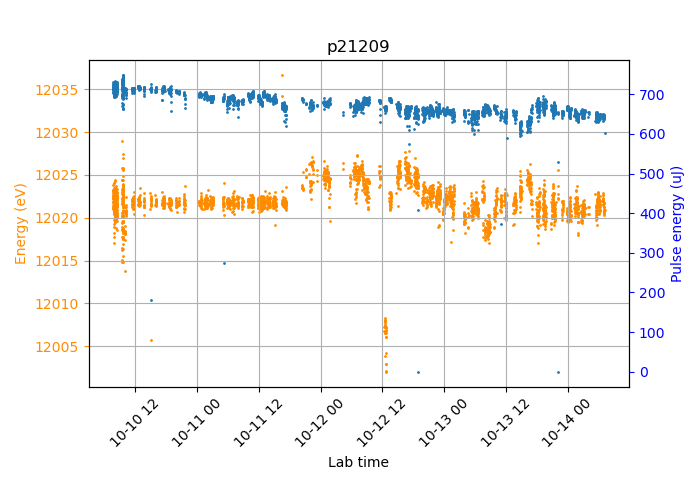

In [21]:
fig = plt.figure(figsize = (7,5))

ax1 = fig.add_subplot(111)
ax2 = plt.twinx(ax1)

ax1.scatter(timestamps, psss_com, color = 'darkorange', s=1)
ax2.scatter(timestamps, pulseEnergy, s=1)

# ax1.plot(psss_com, color = 'darkorange')
# ax2.plot(pulseEnergy)

ax1.tick_params('x', labelrotation=45)
ax1.set_ylabel('Energy (eV)')
ax1.yaxis.label.set_color('darkorange')
ax1.tick_params(axis='y', colors='darkorange')

ax2.set_ylabel('Pulse energy (uJ)')
ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')

ax1.set_xlabel('Lab time')
#ax1.set_ylim(12025, 12060)
ax1.set_title(pgroup)

ax1.grid()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [5]:
bsread_file = fc.selected

channel_list = [channel_PSSS_x, channel_PSSS_y, channel_Izero122, channel_Izero117, channel_GasMonitor]

print ("Loading data from file {}".format(bsread_file))

results = load_data_compact(channel_list, bsread_file)
Data_PBPS122 = results[channel_Izero122]
Data_PBPS117 = results[channel_Izero117]
Data_GasM = results[channel_GasMonitor]
Data_PSSS = results[channel_PSSS_y]
Data_PSSS_Energy = results[channel_PSSS_x]


Loading data from file /gpfs/photonics/swissfel/raw/alvra-staff/p18389/TD1_1us_pump_dark/run_000915.BSREAD.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet            9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARFE10-PBPG050:HAMP-INTENSITY-AVG 9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARFE10-PSSS059:SPECTRUM_X         9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARFE10-PSSS059:SPECTRUM_Y         9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY          9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY          9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 9999 / 9999 -> 0% loss

--------------------------------------------------------------------------------

FEL rep rate is 50.0 Hz


<IPython.core.display.Javascript object>


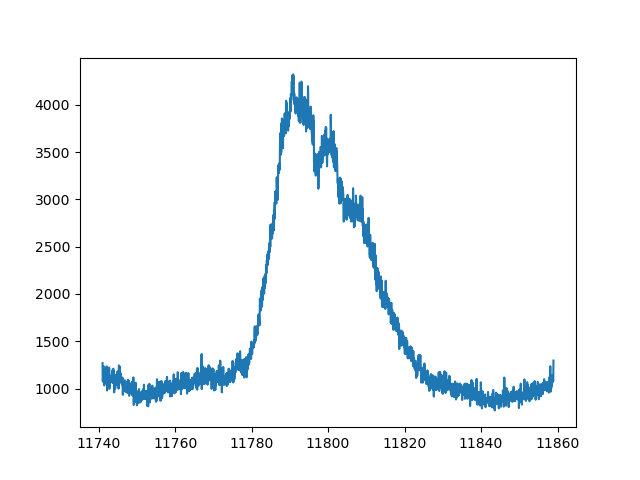

In [17]:
plt.figure()
plt.plot(Data_PSSS_Energy[0], Data_PSSS.mean(axis=0))
plt.show()

PBPS data have 5000 shots, avg intensity = 2.2189 +/- 0.4973
GasM data have 5000 shots, avg intensity = 4.6084 +/- 1.3576


<IPython.core.display.Javascript object>


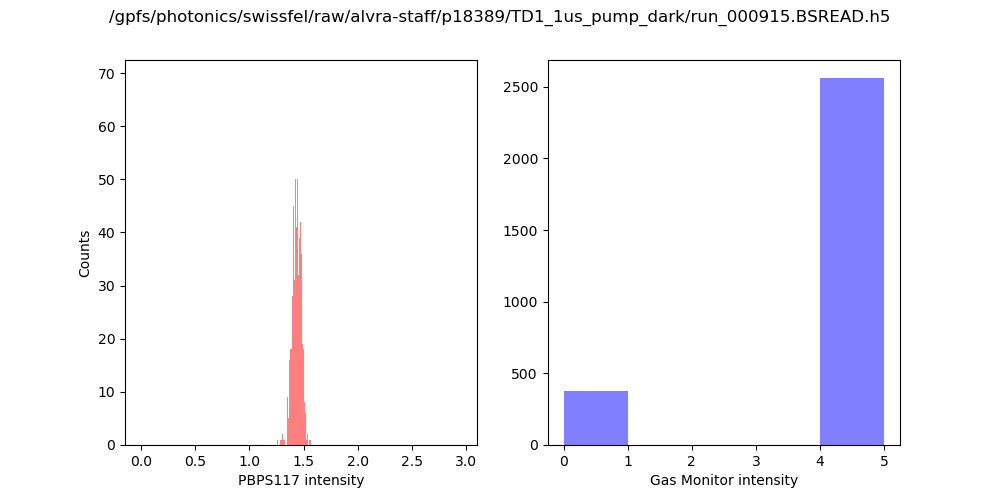

In [12]:
conditionGeneral = Data_PBPS117 > 0.0
Data_GasM_corr = Data_GasM[conditionGeneral]

print ("PBPS data have {} shots, avg intensity = {} +/- {}".format(len(Data_PBPS117),round(np.average(Data_PBPS117),4), round(np.std(Data_PBPS117),4)))
print ("GasM data have {} shots, avg intensity = {} +/- {}".format(len(Data_GasM),round(np.average(Data_GasM),4), round(np.std(Data_GasM),4)))

plt.figure(figsize = (10,5))

plt.suptitle(bsread_file, fontsize=12)
plt.subplot(1,2,1)
plt.hist(Data_PBPS122, bins =np.arange(0, np.max(Data_PBPS117),0.001), facecolor='red', alpha=0.5)
plt.ylabel ("Counts")
plt.xlabel("PBPS117 intensity")

plt.subplot(1,2,2)
plt.hist(Data_GasM, bins =np.arange(0,np.max(Data_GasM),1), facecolor='blue', alpha=0.5)

plt.xlabel("Gas Monitor intensity")
plt.show()
#print (IzeroFEL_pump_original.size, IzeroFEL_pump_shot.size)

In [ ]:
!h5ls -d "/sf/alvra/data/p17589/res/OATT53_tests/20200225_motor5_pos-15_12kev.h5/SARFE10-PBPG050:HAMP-INTENSITY-CAL"


In [35]:
number_shots = []
for i in range(0,10):
    filename = DIR + scan_name + "_step000%s.BSREAD.h5" % i
    data, pid = load_single_channel(filename, channel_LaserDiode, 18)
    number_shots.append(len(data))
    
